<a href="https://colab.research.google.com/github/Shanks1234567/CSE366LAB/blob/main/AI_Lab_05a_Pretrained_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rifat963/pumpkin")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2


In [19]:
import shutil

src = '/root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2'
dst = '/content'

shutil.copytree(src, dst, dirs_exist_ok=True)

'/content'

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data transforms for training and validation

In [80]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [81]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [82]:
# Load and train models
models_to_train = {
    'resnet18': models.resnet18(pretrained=True),
   # 'efficientnet_b0': models.efficientnet_b0(pretrained=True),
   # 'inception_v3': models.inception_v3(pretrained=True, aux_logits=True),
    'mobilenet_v3_small': models.mobilenet_v3_small(pretrained=True),
    'densenet161': models.densenet161(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the 

In [83]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [84]:


def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif 'inception' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'mobilenet' in model_name:
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curve
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()




Training model: resnet18
Epoch 1/2
Train Loss: 0.7713 Acc: 0.7069
Val Loss: 0.5441 Acc: 0.8070
Epoch 2/2
Train Loss: 0.4814 Acc: 0.8190
Val Loss: 0.5237 Acc: 0.8221

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.75      0.76      0.76        76
       Downy Mildew       0.80      0.87      0.84        79
       Healthy Leaf       0.82      0.95      0.88        80
     Mosaic Disease       0.91      0.93      0.92        72
     Powdery_Mildew       0.84      0.63      0.72        92

           accuracy                           0.82       399
          macro avg       0.82      0.83      0.82       399
       weighted avg       0.82      0.82      0.82       399

Confusion Matrix:
Confusion matrix, without normalization
[[58  2 13  0  3]
 [ 2 69  0  2  6]
 [ 4  0 76  0  0]
 [ 0  3  0 67  2]
 [13 12  4  5 58]]


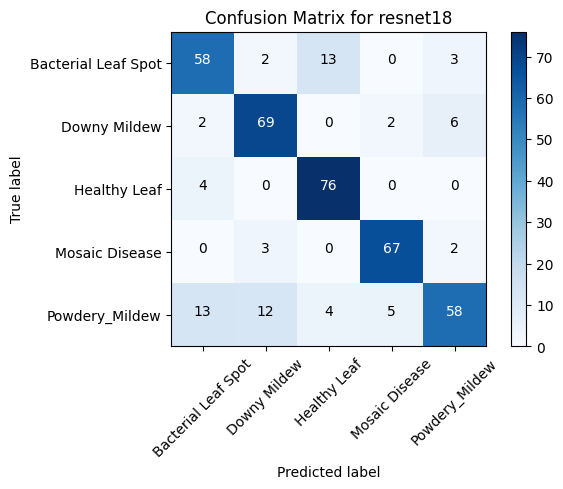

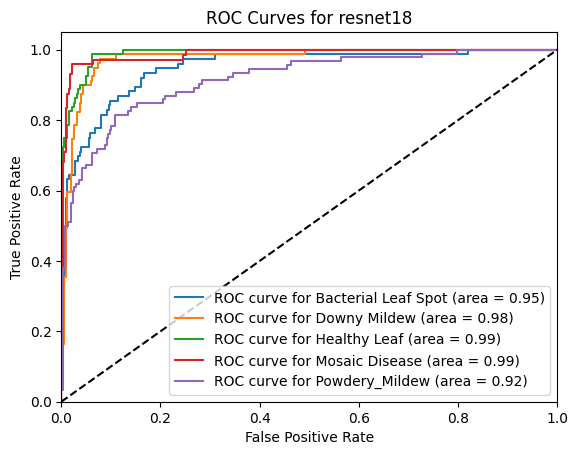


Training model: mobilenet_v3_small
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.0475 Acc: 0.6364
Val Loss: 0.7426 Acc: 0.7419
Epoch 2/2
Train Loss: 0.6136 Acc: 0.7826
Val Loss: 0.6563 Acc: 0.7845

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.66      0.75      0.70        76
       Downy Mildew       0.81      0.85      0.83        79
       Healthy Leaf       0.76      0.94      0.84        80
     Mosaic Disease       0.87      0.90      0.88        72
     Powdery_Mildew       0.89      0.53      0.67        92

           accuracy                           0.78       399
          macro avg       0.80      0.79      0.78       399
       weighted avg       0.80      0.78      0.78       399

Confusion Matrix:
Confusion matrix, without normalization
[[57  3 12  0  4]
 [ 4 67  3  3  2]
 [ 5  0 75  0  0]
 [ 1  5  1 65  0]
 [20  8  8  7 49]]


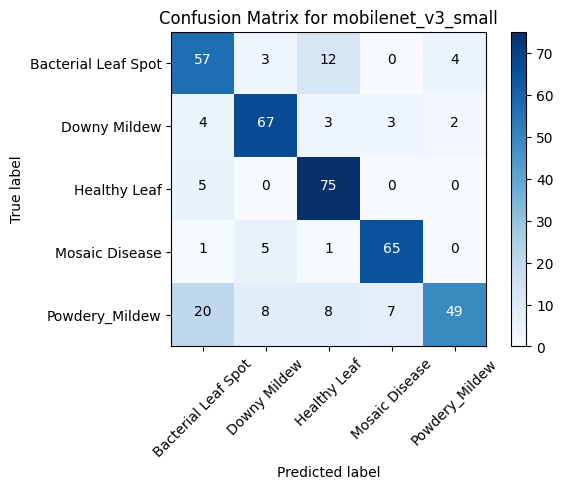

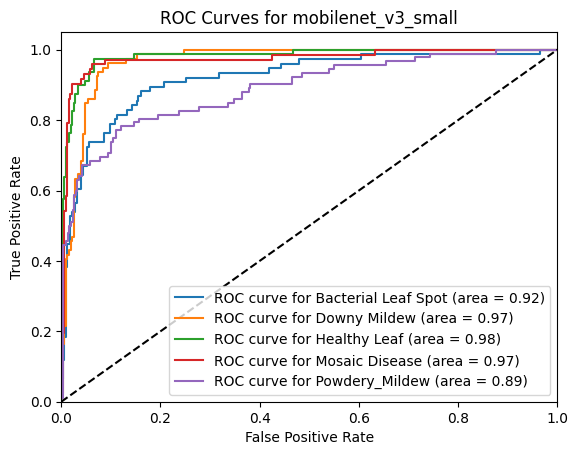


Training model: densenet161
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.1559 Acc: 0.7343
Val Loss: 0.5159 Acc: 0.8496
Epoch 2/2
Train Loss: 0.3932 Acc: 0.8495
Val Loss: 0.5782 Acc: 0.8246

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.69      0.83      0.75        76
       Downy Mildew       0.79      0.90      0.84        79
       Healthy Leaf       0.95      0.75      0.84        80
     Mosaic Disease       0.93      0.94      0.94        72
     Powdery_Mildew       0.82      0.73      0.77        92

           accuracy                           0.82       399
          macro avg       0.84      0.83      0.83       399
       weighted avg       0.84      0.82      0.83       399

Confusion Matrix:
Confusion matrix, without normalization
[[63  4  2  0  7]
 [ 1 71  0  1  6]
 [20  0 60  0  0]
 [ 0  2  0 68  2]
 [ 7 13  1  4 67]]


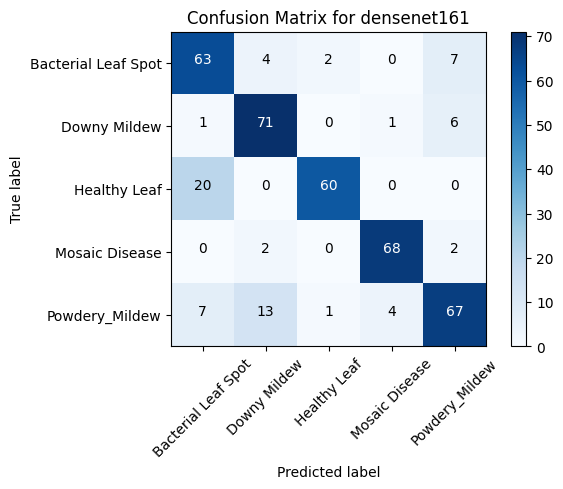

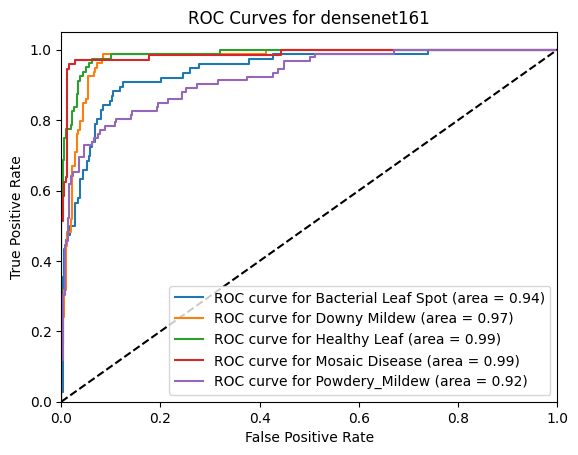

In [85]:
# Loop through each pretrained model, train and evaluate
for model_name, model in models_to_train.items():
    train_and_evaluate_model(model, model_name)

# Data transforms for training and validation

In [59]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.299, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.299, 0.225])
    ]),
}

In [60]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [61]:
# Load and train models
models_to_train = {
   # 'resnet18': models.resnet18(pretrained=True),

    'inception_v3': models.inception_v3(pretrained=True, aux_logits=True),
   # 'mobilenet_v3_small': models.mobilenet_v3_small(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [65]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif 'inception' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'mobilenet' in model_name:
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get the main output (logits) from InceptionOutputs
                    outputs = model(inputs)
                    if isinstance(outputs, models.inception.InceptionOutputs):
                        outputs = outputs.logits

                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curve
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()




Training model: inception_v3
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.0387 Acc: 0.6181
Val Loss: 0.6019 Acc: 0.7870
Epoch 2/2
Train Loss: 0.5105 Acc: 0.8255
Val Loss: 0.5246 Acc: 0.8045

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.70      0.78      0.74        76
       Downy Mildew       0.81      0.84      0.82        79
       Healthy Leaf       0.90      0.81      0.86        80
     Mosaic Disease       0.93      0.86      0.89        72
     Powdery_Mildew       0.73      0.75      0.74        92

           accuracy                           0.80       399
          macro avg       0.81      0.81      0.81       399
       weighted avg       0.81      0.80      0.81       399

Confusion Matrix:
Confusion matrix, without normalization
[[59  3  5  0  9]
 [ 1 66  0  1 11]
 [15  0 65  0  0]
 [ 0  4  0 62  6]
 [ 9  8  2  4 69]]


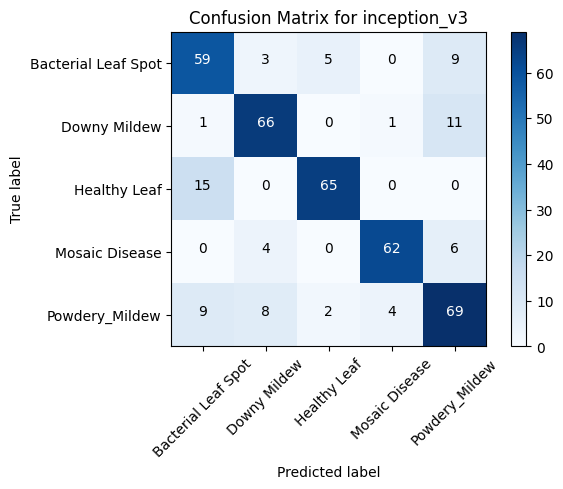

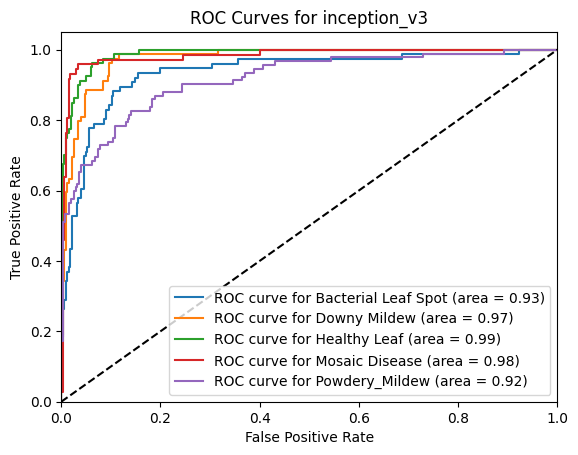

In [66]:
# Loop through each pretrained model, train and evaluate
for model_name, model in models_to_train.items():
    train_and_evaluate_model(model, model_name)

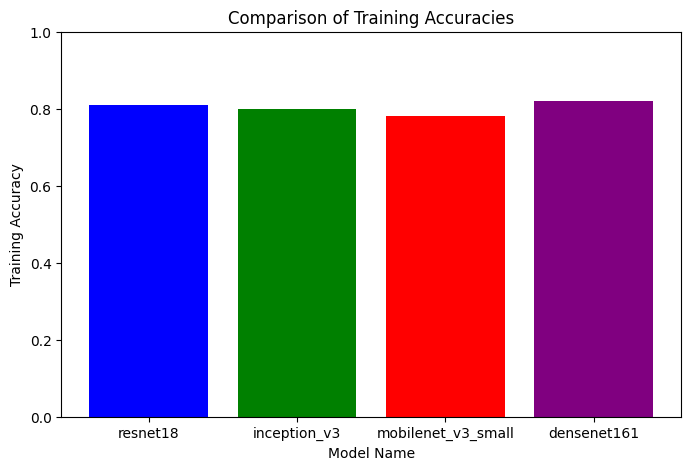

In [86]:
import matplotlib.pyplot as plt

# Example accuracy values (replace with actual values from your training)
accuracy_dict = {
    'resnet18': 0.81,

    'inception_v3': 0.80,
    'mobilenet_v3_small': 0.78,
    'densenet161':0.82
}

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=['blue', 'green', 'red', 'purple'])

# Labels and title
plt.xlabel("Model Name")
plt.ylabel("Training Accuracy")
plt.title("Comparison of Training Accuracies")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

# Show the plot
plt.show()
